<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegGPT/Inference_with_SegGPT_for_one_shot_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with SegGPT for one-shot image segmentation

In this notebook, we'll illustrate how we can leverage SegGPT for segmenting (painting) things in a new image based on just a single (image, mask) prompt.

* Docs: https://huggingface.co/docs/transformers/main/en/model_doc/seggpt
* Paper: https://arxiv.org/abs/2304.03284.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/seggpt_overview.jpg"
alt="drawing" width="600"/>

<small> SegGPT overview. Taken from the <a href="https://arxiv.org/abs/2304.03284">original paper.</a> </small>


## Set-up environment

Let's start by installing the Transformers library from source, since the model is brand new at the time of writing.

In [111]:
!pip install --upgrade git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-mfhhtya6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-mfhhtya6
  Resolved https://github.com/huggingface/transformers.git to commit 0ad770c3733f9478a8d9d0bc18cc6143877b47a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load model

Next, let's load the SegGPT model along with its processor.

In [112]:
from transformers import SegGptImageProcessor, SegGptForImageSegmentation

checkpoint = "BAAI/seggpt-vit-large"
image_processor = SegGptImageProcessor.from_pretrained(checkpoint)
model = SegGptForImageSegmentation.from_pretrained(checkpoint)

## Load image together with prompt

SegGPT works by providing an image you want to paint a segmentation mask over, along with an example image and its corresponding ground truth mask. This is also called "one-shot segmentation" since we provide one example to the model.

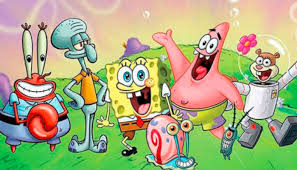

In [113]:
from PIL import Image
import requests

image_input_url = "https://raw.githubusercontent.com/baaivision/Painter/main/SegGPT/SegGPT_inference/examples/hmbb_2.jpg"
image_prompt_url = "https://raw.githubusercontent.com/baaivision/Painter/main/SegGPT/SegGPT_inference/examples/hmbb_1.jpg"
mask_prompt_url = "https://raw.githubusercontent.com/baaivision/Painter/main/SegGPT/SegGPT_inference/examples/hmbb_1_target.png"

image_input = Image.open(requests.get(image_input_url, stream=True).raw)
image_prompt = Image.open(requests.get(image_prompt_url, stream=True).raw)
mask_prompt = Image.open(requests.get(mask_prompt_url, stream=True).raw)
image_input

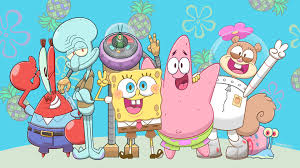

In [114]:
image_prompt

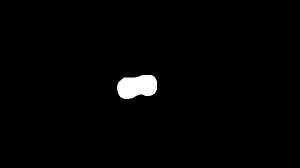

In [115]:
mask_prompt

## Forward pass

We prepare the image and prompt for the model and perform a forward pass.

In [116]:
import torch

inputs = image_processor(images=image_input, prompt_images=image_prompt, prompt_masks=mask_prompt, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

In [117]:
list(outputs.pred_masks.shape)

[1, 3, 896, 448]

## Visualize

Finally, we can visualize the mask! For that we first postprocess the model outputs in order to get a semantic segmentation map, which contains a label per pixel.

In [118]:
target_sizes = [image_input.size[::-1]]
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)[0]
print(predicted_segmentation_map)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


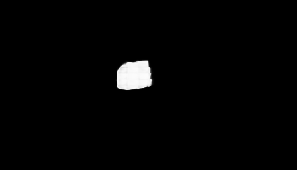

In [120]:
visual_predicted_mask = predicted_segmentation_map.numpy().astype(np.uint8)
Image.fromarray(visual_predicted_mask)

For visualization, we define a so-called color palette which maps each class to a corresponding color.

In [121]:
def color_palette():
    """Color palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

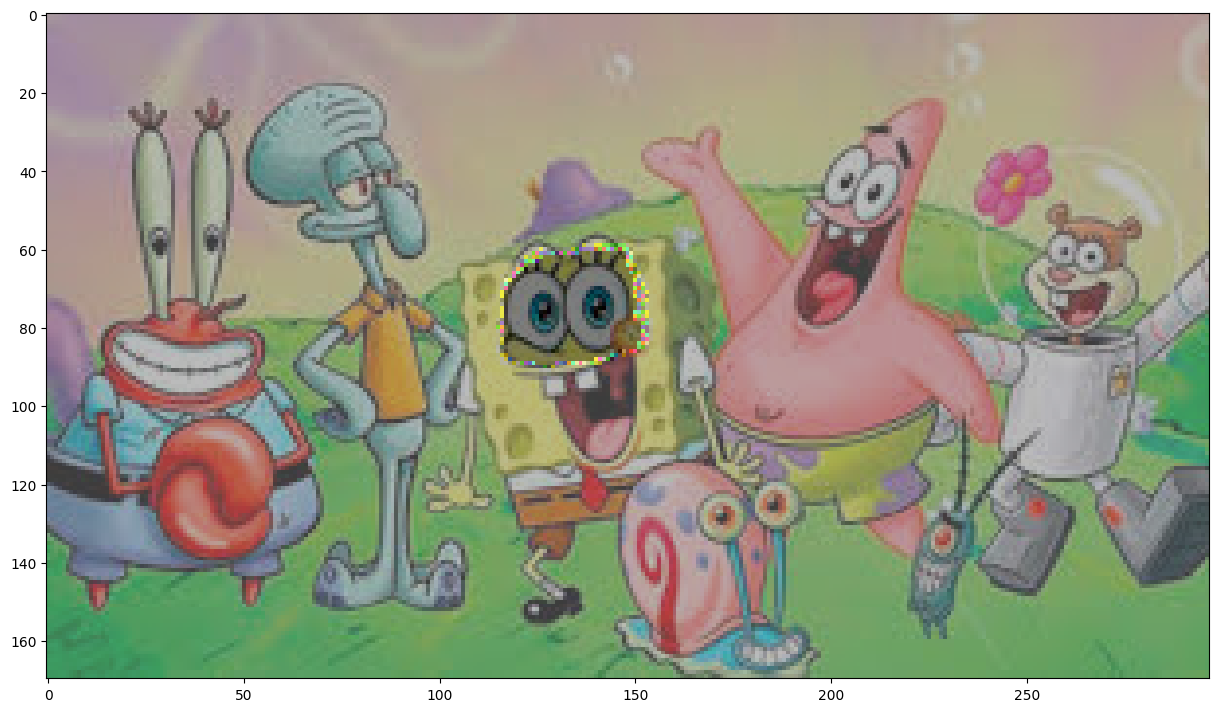

In [122]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(color_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image_input) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

# Working with predefined number of labels

Whenever you have a dataset with a predefined number of labels (like the [ADE-150 dataset](https://huggingface.co/datasets/scene_parse_150), which has 150 semantic categories) you can pass `num_labels` to `SegGptImageProcessor` when preprocessing the inputs. This will lead to the creation of a color palette under the hood that will map the semantic map of prompt masks to RGB and then use the same `num_labels` when post-processing. Let's use the `FoodSeg103` dataset as an example.

In [123]:
!pip install -q datasets

In [124]:
def plot_images(image_list: list[np.ndarray], titles: str, rows: int, **kwargs):
    cols = len(image_list) // rows
    fig, axes = plt.subplots(rows, cols, **kwargs)
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(title)
    plt.tight_layout()

Let's get a few images that share classes and see what we get when using the `num_labels`.

In [125]:
from datasets import load_dataset

ds_id = "EduardoPacheco/FoodSeg103"
ds = load_dataset(ds_id, split="train")

image_input = ds[4]["image"]
ground_truth = ds[4]["label"]
image_prompt = ds[29]["image"]
mask_prompt = ds[29]["label"]

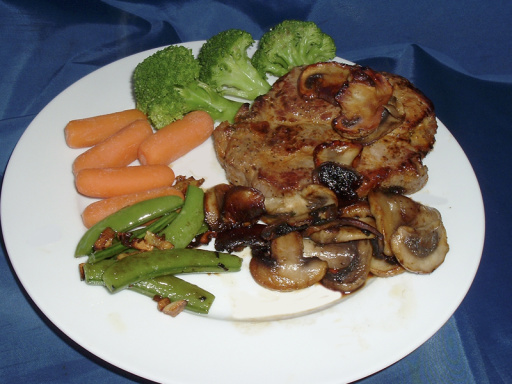

In [126]:
image_input

In [127]:
# Prediction and post process function for ease
def predict(
    model: SegGptForImageSegmentation=model,
    image_processor: SegGptImageProcessor=image_processor,
    images: Image.Image=image_input,
    prompts: Image.Image=image_prompt,
    masks: Image.Image=mask_prompt,
    num_labels: int = None,
    device: str="cpu"
) -> torch.Tensor:
    inputs = image_processor(images=images, prompt_images=prompts, prompt_masks=masks, return_tensors="pt", num_labels=num_labels)
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = [images.size[::-1]]
    mask = image_processor.post_process_semantic_segmentation(outputs, target_sizes, num_labels=num_labels)[0]

    return mask

In [128]:
# FoodSeg103 has actually 104 classes considering the background, but we should
# not account the background when setting num_labels.
num_labels = 103
palette = image_processor.get_palette(num_labels)

# 104 because by default class_idx = 0 is set to BG and mapped to (0,0,0) RGB
len(palette)

104

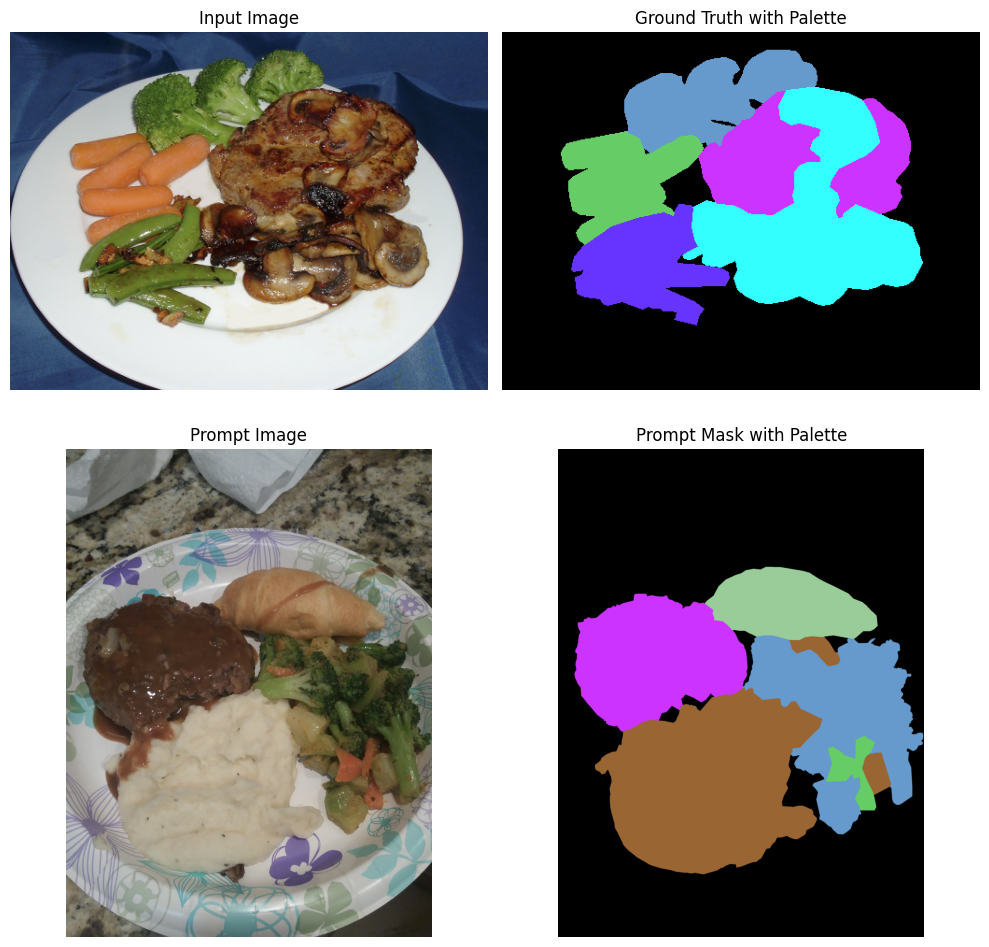

In [129]:
# Visualizing images and masks
images = [
    np.array(image_input),
    image_processor.mask_to_rgb(np.array(ground_truth), palette, data_format="channels_last"),
    np.array(image_prompt),
    image_processor.mask_to_rgb(np.array(mask_prompt), palette, data_format="channels_last"),
]
titles = [
    "Input Image",
    "Ground Truth with Palette",
    "Prompt Image",
    "Prompt Mask with Palette",
]

plot_images(images, titles, rows=2, figsize=(10,10))

In [130]:
pred_without_palette = predict()
pred_with_palette = predict(num_labels=num_labels)

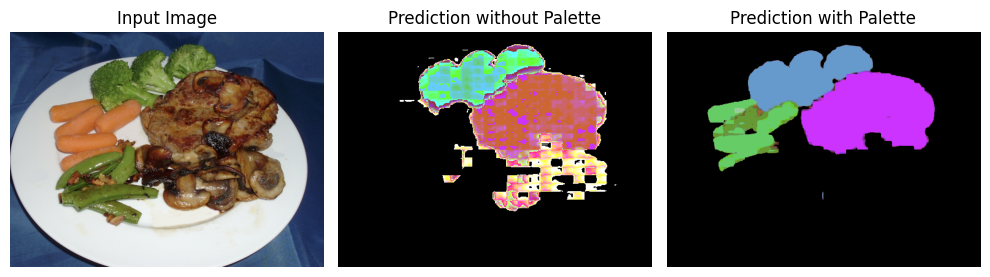

In [131]:
images = [
    np.array(image_input),
    image_processor.mask_to_rgb(pred_without_palette.numpy(), palette, data_format="channels_last"),
    image_processor.mask_to_rgb(pred_with_palette.numpy(), palette, data_format="channels_last"),
]

titles = [
    "Input Image",
    "Prediction without Palette",
    "Prediction with Palette"
]

plot_images(images, titles, rows=1, figsize=(10,10))